In [1]:
%load_ext autoreload
%autoreload 2  # Autoreload all modules
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# libs
import glob
import pandas as pd
import random
import pprint
pp = pprint.PrettyPrinter(indent=4)
#import importlib

import itertools
from collections import Counter
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np

from nltk import sent_tokenize
from nltk.tokenize import word_tokenize

import networkx as nx

from tqdm import tqdm

# perso
import sys
sys.path.append('utils/')
sys.path.append('argdisc/')

sys.path.insert(1, '/Users/lhuber/Documents/Research/Phd/workdir/SciDTB/code/probing/')

from data_mgmt import *
from graphs_utils import *
from moves_utils import *
from corpus_utils import Corpus
from preprocessing_utils import *
from arg_ana import *
from arg_disc_ana import *
from gspan import *

# Load Data

In [2]:
# Import corpus to dataframe (text and units)

# the corpus is organized following 3 directories
# in each directory, some files are annotated by multiple annotators
# we take all the uniq documents (just 1 annotator)
pathtodirtrain = "data/train/"
pathtodirtest  = "data/test/gold/"
pathtodirdev   = "data/dev/gold/"
#pathtographs   = "../data/SciDTB/graphimages/"
#path2properties = "../data/SciDTB_articles_properties.csv"


# considere only 1 annotator (taken randomly)
allano = "*.dep"
files = glob.glob(pathtodirtrain+allano) # for train keep only one annotator
# remove duplicate documents (other annotators)
files = [x for x in files if "anno2" not in x and "anno3" not in x] 
files += glob.glob(pathtodirtest+allano)
files += glob.glob(pathtodirdev+allano)

c = Corpus(files=files)

In [3]:
arg_annots = "data/scidtb_argmin_annotations/*.conll.good"
basename = "data/scidtb_argmin_annotations/"
endname = "-fexp-corpus.conll.good"
arg_files = [x for x in glob.glob(arg_annots)]

docs = []
for file in arg_files:
    docname = file.replace(basename, "")
    docname = docname.replace(endname, "")
    docs.append(docname)
    
argdiscdtf = c.corpus.loc[docs]

In [4]:
argdiscdtf["arg_annot"] = argdiscdtf.apply(lambda x: get_arg_annot(basename+x.name+endname), axis=1)
argdiscdtf["arg_graph"] = argdiscdtf.apply(lambda x: get_arg_graph(x.arg_annot), axis=1)
argdiscdtf["arg_sents"] = argdiscdtf.apply(lambda x: get_arg_sents(get_arg_annot(basename+x.name+endname)), axis=1)
argdiscdtf["segtxt"] = argdiscdtf.apply(lambda row: preprocess(row.segments), axis=1)
argdiscdtf["argtxt"] = argdiscdtf.apply(lambda row: preprocess(row.arg_sents), axis=1)
argdiscdtf["edus_adus_mapping"] = argdiscdtf.apply(lambda row: to_edus_adus_mapping(row.argtxt, row.segtxt), axis=1)
argdiscdtf["adus_edus_mapping"] = argdiscdtf.apply(lambda row: remove_nones(to_adus_edus_mapping(row.edus_adus_mapping)), axis=1)
argdiscdtf["sents_edus_mapping"] = argdiscdtf.apply(lambda row: to_sent_edus_mapping(row.edus_sent_ids), axis=1)
docnames = argdiscdtf.index.to_list()

# Data Preparation

In [5]:
adusentdtf = argdiscdtf[["segments", "edus_adus_mapping", 
                         "adus_edus_mapping", "sents_edus_mapping"]]

## Prepare Arg / Sent data

In [6]:
adusentdtf["has_sim_arg_sent"] = adusentdtf.apply(lambda row: has_sim_seg(row.adus_edus_mapping, row.sents_edus_mapping), axis=1)
adusentdtf["sim_arg_sent"] = adusentdtf.apply(lambda row: sim_seg(row.adus_edus_mapping, row.sents_edus_mapping), axis=1)
adusentdtf["prop_sim_arg_sent"] = adusentdtf.apply(lambda row: prop_sim_seg(row.sim_arg_sent), axis=1)

In [7]:
notmapped = adusentdtf[adusentdtf["prop_sim_arg_sent"] != 1]

In [8]:
notmapped = notmapped[["adus_edus_mapping", "sents_edus_mapping", "sim_arg_sent"]]

In [9]:
notmapped["notmapped_args"] = notmapped.apply(lambda row: {k:v for k,v in row.sim_arg_sent.items() if v == False}, axis=1)

In [10]:
notmapped["notmapped_args"] = notmapped.apply(lambda row: {k: row.adus_edus_mapping[k] for k,v in row.notmapped_args.items()}, axis=1)

# Prepare Type data

In [11]:
typedtf = argdiscdtf[["adus_edus_mapping", "graph"]] 

In [12]:
typedtf["arg_annot"] = argdiscdtf["arg_annot"]

In [13]:
typedtf["arg_types"] = typedtf.apply(lambda x: get_arg_types(x.arg_annot), axis=1)

In [14]:
typedtf["arg_subs"] = typedtf.apply(lambda x: get_arg_subs(x.adus_edus_mapping, x.graph), axis=1)

In [15]:
assert [len(x) for x in typedtf["arg_types"]] == [len(x) for x in typedtf["arg_subs"]]

# Analysis

## Arg / Sent segments boundaries analysis

### Number of args that do not map with sentence

In [16]:
sum([len(x) for x in notmapped["notmapped_args"]])

59

### Calculate arg and sentence mapping

In [17]:
sents = list(notmapped["sents_edus_mapping"])
adus = list(notmapped["notmapped_args"])
docnames = notmapped.index.to_list()
sent_mappings = [get_sent_mapping(a,s) for a,s in zip(adus, sents)]
arg_mappings = [get_adu_mapping(a,s) for a,s in zip(adus, sents)]

### Args bigger than sentences

In [18]:
for i, d in enumerate(arg_mappings):
    if d != {}:
        print(docnames[i])
        print(d)

D14-1043
{0: [0, 1]}
D14-1020
{1: [1, 2]}


### Sentences bigger then args

#### Plot distrib len sents (in nb of edus) global

In [19]:
all_args_edus = [list(doc.values()) for doc in list(adusentdtf["sents_edus_mapping"])]

In [20]:
all_args_edus_lens = [len(x) for doc in all_args_edus for x in doc]

(array([ 65., 120.,  75.,  38.,   0.,  15.,  11.,   4.,   0.,   2.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

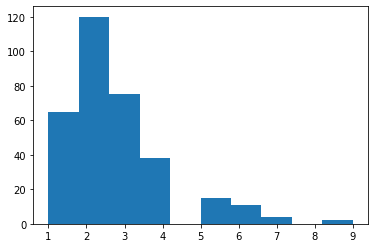

In [21]:
plt.hist(all_args_edus_lens)

#### Vs distrib len sents (in nb of edus) for sentences having than 1 arg

In [22]:
## Calculate number of edus for each sentence made of more than 1 argument
nb_edus_sent_mapping = []
edus_sent_mapping = []
docs = []
for i, smap in enumerate(sent_mappings):
    doc = docnames[i]
    if smap != {}:
        #print(sents[i][])
        for sid, sent in smap.items():
            docs.append(docnames[i])
            nb_edus_sent_mapping.append(len(sents[i][sid]))
            edus_sent_mapping.append((doc, sents[i][sid]))


In [23]:
Counter(nb_edus_sent_mapping)

Counter({6: 6, 4: 2, 3: 8, 5: 4, 2: 9, 7: 1})

(array([9., 0., 8., 0., 2., 0., 4., 0., 6., 1.]),
 array([2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ]),
 <BarContainer object of 10 artists>)

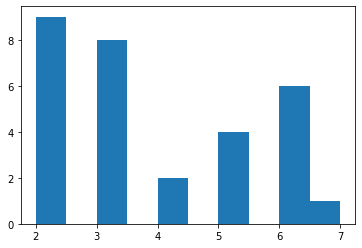

In [24]:
plt.hist(nb_edus_sent_mapping)

## Argumentation discourse structure analysis

In [25]:
mappings = argdiscdtf["adus_edus_mapping"]
graphs = argdiscdtf.graph

In [26]:
mappings = argdiscdtf["adus_edus_mapping"]
graphs = argdiscdtf.graph
macrographs = [get_arg_macrog(m, g) for m,g in zip(mappings, graphs)]
arggraphs = [get_arg_graph(x) for x in argdiscdtf["arg_annot"]]

### Structure

In [27]:
macrocomp = pd.DataFrame({"arggraph": arggraphs,
                          "discmacrograph": macrographs})

In [28]:
macrocomp["sim_dirrels"] = macrocomp.apply(lambda row: prop_sim_rels(row.arggraph, row.discmacrograph, direc=True), axis=1)
macrocomp["sim_rels"] = macrocomp.apply(lambda row: prop_sim_rels(row.arggraph, row.discmacrograph), axis=1)
macrocomp["sim_labrels"] = macrocomp.apply(lambda row: prop_sim_rels(row.arggraph, row.discmacrograph, labels=True), axis=1)

#### Undirected

In [29]:
macrocomp["sim_rels"].describe()

count    60.000000
mean      0.772579
std       0.194196
min       0.250000
25%       0.666667
50%       0.750000
75%       1.000000
max       1.000000
Name: sim_rels, dtype: float64

#### Directed

In [30]:
macrocomp["sim_dirrels"].describe()

count    60.000000
mean      0.668135
std       0.261377
min       0.000000
25%       0.500000
50%       0.666667
75%       1.000000
max       1.000000
Name: sim_dirrels, dtype: float64

### Labels

In [31]:
mappings = [rels_mapping(mg, ag) for mg, ag in zip(macrographs, arggraphs)]
merged_map = merge_dict(mappings)
merge_map_count = {k: dict(Counter(flat(v))) for k,v in merged_map.items()}

In [32]:
merge_map_count

{'elab-addition': {'detail': 25, 'support': 11},
 'elab-process_step': {'detail': 7},
 'evaluation': {'detail': 1, 'support': 47},
 'result': {'additional': 4, 'detail': 1, 'support': 1},
 'bg-goal': {'support': 10},
 'elab-aspect': {'detail': 22, 'support': 4},
 'progression': {'detail': 6},
 'manner-means': {'detail': 18, 'support': 1},
 'joint': {'detail': 4},
 'bg-compare': {'support': 8},
 'bg-general': {'support': 2, 'detail': 1},
 'summary': {'detail': 1, 'support': 1},
 'exp-evidence': {'support': 5},
 'enablement': {'detail': 1},
 'exp-reason': {'detail': 1},
 'contrast': {'additional': 3},
 'elab-example': {'detail': 1},
 'attribution': {'detail': 1},
 'cause': {'additional': 1},
 'elab-enum_member': {'detail': 1}}

#### Elab-addition

In [33]:
docs_with_elab_add = []
for docname, m in zip(docnames, mappings):
    if "elab-addition" in m.keys():
        docs_with_elab_add.append(docname)

In [34]:
argdiscdtf["disc_macro_graph"] = macrographs 
elabdtf = argdiscdtf.loc[docs_with_elab_add]
elabdtf = elabdtf[["arg_graph", "graph", "disc_macro_graph"]]

#### Distrib mapping based on position in tree

In [35]:
root_rels = []
for doc, gphs in elabdtf.iterrows():
    arg = gphs["arg_graph"]
    disc = gphs["disc_macro_graph"]
    root_rels.append(elab_root_rels(arg, disc))
#print(root_rels)
elabdtf["root_elabs"] = root_rels

In [36]:
elabdtf["root_elabs"] 

docname
D14-1045           []
D14-1002           []
D14-1041       [None]
D14-1034     [detail]
D14-1024    [support]
D14-1056     [detail]
D14-1052     [detail]
D14-1016           []
Name: root_elabs, dtype: object

#### Distrib mapping based on relation sequence

In [37]:
#for doc, gphs in elabdtf.iterrows():
    #print(doc)
    #draw_graph(gphs["arg_graph"])
    #draw_graph(gphs["disc_macro_graph"])

## Argumentation type analysis

In [38]:
args_per_type = {}
for subs, types in zip(typedtf["arg_subs"], typedtf["arg_types"]):
    for sub, typ in zip(subs, types):
        if typ not in args_per_type.keys():
            args_per_type[typ] = [sub]
        else:
            args_per_type[typ].append(sub)

### Nb args of each type

In [39]:
for k, subs in args_per_type.items():
    print(k)
    print(len(subs))

proposal
110
description
7
means
63
observation
11
assertion
88
result
74


### Distrib len per type

In [40]:
types_lens = {k:[len(x.nodes) for x in v] for k,v in args_per_type.items()}
arrays = types_lens.values()

In [41]:
n_bins=6

In [42]:
colors = ['blue', 'orange', 'green', "yellow", "red", "pink"]
names = list(types_lens.keys())

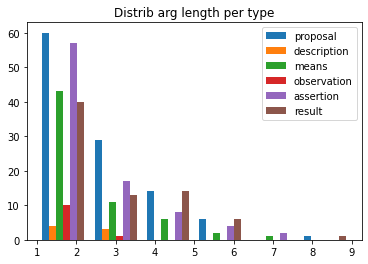

In [43]:
plt.hist(arrays, n_bins, histtype='bar', label=names)
plt.legend(loc="upper right")
plt.title('Distrib arg length per type')
plt.show()

### Distrib rels per type

In [44]:
type_rels_temp = {k:[list(x.edges(data=True)) for x in v] for k,v in args_per_type.items()}
type_rels = {}
for k, docv in type_rels_temp.items():
    type_rels[k] = []
    #print(v)
    for v in docv:
        for edge in v:
            #print(edge)
            type_rels[k].append(edge[2]["label"])

In [45]:
type_rels_temp = {k:[list(x.edges(data=True)) for x in v] for k,v in args_per_type.items()}
nb_rels_doc = {}
for k, docv in type_rels_temp.items():
    nb_rels_doc[k] = []
    #print(v)
    for v in docv:
        #print(v)
        nb_rels_doc[k].append(len(v))
    nb_rels_doc[k] = np.mean(nb_rels_doc[k])


In [46]:
nb_rels_doc

{'proposal': 1.6,
 'description': 1.0,
 'means': 1.1904761904761905,
 'observation': 0.45454545454545453,
 'assertion': 1.3295454545454546,
 'result': 1.6891891891891893}

#### Nb rels
/!\ Certains types ont moins de rels que de EDUs, c'est lorsque des args sont composés d'une seule edu

In [47]:
for k, rels in type_rels.items():
    print(k)
    print(len(rels))

proposal
176
description
7
means
75
observation
5
assertion
117
result
125


In [48]:
### Distrib rels per type

In [49]:
type_rels_cnt = {k:Counter(v) for k,v in type_rels.items()}

In [50]:
type_rels_cnt

{'proposal': Counter({'enablement': 36,
          'progression': 9,
          'elab-enum_member': 6,
          'elab-addition': 69,
          'contrast': 9,
          'manner-means': 16,
          'temporal': 3,
          'bg-general': 4,
          'elab-example': 5,
          'joint': 10,
          'same-unit': 1,
          'attribution': 4,
          'cause': 1,
          'condition': 1,
          'result': 1,
          'comparison': 1}),
 'description': Counter({'elab-example': 1,
          'elab-addition': 5,
          'elab-enum_member': 1}),
 'means': Counter({'manner-means': 6,
          'enablement': 21,
          'joint': 13,
          'bg-general': 3,
          'elab-addition': 24,
          'elab-enum_member': 1,
          'exp-reason': 1,
          'attribution': 1,
          'progression': 1,
          'elab-example': 1,
          'same-unit': 2,
          'contrast': 1}),
 'observation': Counter({'elab-addition': 2,
          'manner-means': 1,
          'comparison': 1,


### Distrib rels seqs per type

proposal


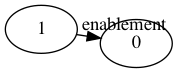

description


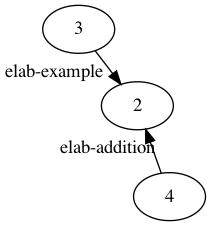

means


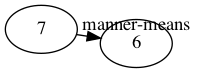

observation


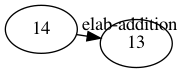

assertion


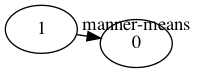

result


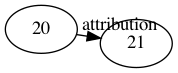

In [51]:
for k, v in args_per_type.items():
    print(k)
    draw_graph(v[0])

In [52]:
args_per_type_gspan_out = {k:gspan(v, 1, 2, method=3) for k,v in args_per_type.items()}

In [53]:
all_args = list(args_per_type.values())
all_args = [item for sublist in all_args for item in sublist]

In [54]:
all_args_gspan_out = gspan(all_args, 1, 2, method=2)

In [55]:
def objs(outgspan):
    objs = list(outgspan["isomorph_graphs"])
    objs = [item for sublist in objs for item in sublist]
    return objs

In [56]:
def nb_graphs_having_rel(relname, graphs):
    cnt=0
    for g in graphs:
        labels = [x[2]["label"] for x in g.edges(data=True)]
        if relname in labels:
            cnt+=1
    return cnt

### Subgraph analysis : focus on proposal/means/assertion/result

### Can we distinguish proposal from assertion ? 

In [57]:
len(set(objs(all_args_gspan_out[1])))

263

In [58]:
all_out = all_args_gspan_out
assert_out = args_per_type_gspan_out["assertion"][1]
prop_out = args_per_type_gspan_out["proposal"][1]
means_out = args_per_type_gspan_out["means"][1]
result_out = args_per_type_gspan_out["result"][1]
obs_out = args_per_type_gspan_out["observation"][1]
descr_out = args_per_type_gspan_out["description"][1]

In [59]:
descr_out

,support,graph,graphstr,num_vert,isomorph_graphs
1,1,<gspan_mining.graph.Graph object at 0x133628c10>,v 0 X v 1 X e 0 1 elab-example,2,[0]
2,4,<gspan_mining.graph.Graph object at 0x133628c90>,v 0 X v 1 X e 0 1 elab-addition,2,"[0, 1, 2, 6]"
3,1,<gspan_mining.graph.Graph object at 0x1335d7810>,v 0 X v 1 X v 2 X e 0 1 elab-addition e 1 2 el...,3,[0]
4,1,<gspan_mining.graph.Graph object at 0x1335e5190>,v 0 X v 1 X v 2 X e 0 1 elab-addition e 1 2 el...,3,[2]
5,1,<gspan_mining.graph.Graph object at 0x1335ee7d0>,v 0 X v 1 X v 2 X e 0 1 elab-addition e 1 2 el...,3,[6]
6,1,<gspan_mining.graph.Graph object at 0x1335e5e90>,v 0 X v 1 X e 0 1 elab-enum_member,2,[2]


In [60]:
obs_out

,support,graph,graphstr,num_vert,isomorph_graphs
1,2,<gspan_mining.graph.Graph object at 0x132eff0d0>,v 0 X v 1 X e 0 1 elab-addition,2,"[0, 6]"
2,1,<gspan_mining.graph.Graph object at 0x133379110>,v 0 X v 1 X e 0 1 manner-means,2,[3]
3,1,<gspan_mining.graph.Graph object at 0x1335c1490>,v 0 X v 1 X e 0 1 comparison,2,[6]
4,1,<gspan_mining.graph.Graph object at 0x1335ff950>,v 0 X v 1 X v 2 X e 0 1 comparison e 1 2 elab-...,3,[6]
5,1,<gspan_mining.graph.Graph object at 0x1335c1e90>,v 0 X v 1 X e 0 1 joint,2,[8]


In [61]:
result_out.sort_values(by="support", ascending=False)

,support,graph,graphstr,num_vert,isomorph_graphs
1,40,<gspan_mining.graph.Graph object at 0x1339001d0>,v 0 X v 1 X e 0 1 attribution,2,"[0, 1, 2, 3, 4, 6, 7, 9, 16, 18, 19, 20, 22, 2..."
64,24,<gspan_mining.graph.Graph object at 0x133948e50>,v 0 X v 1 X e 0 1 elab-addition,2,"[3, 5, 6, 7, 10, 12, 15, 22, 27, 29, 30, 31, 3..."
6,12,<gspan_mining.graph.Graph object at 0x133913590>,v 0 X v 1 X v 2 X e 0 1 attribution e 1 2 elab...,3,"[32, 3, 67, 37, 6, 73, 63, 53, 27, 29, 30, 31]"
56,10,<gspan_mining.graph.Graph object at 0x1339050d0>,v 0 X v 1 X e 0 1 joint,2,"[65, 2, 58, 5, 6, 7, 42, 13, 22, 26]"
111,8,<gspan_mining.graph.Graph object at 0x1339b4750>,v 0 X v 1 X e 0 1 manner-means,2,"[32, 66, 37, 7, 8, 44, 45, 61]"
...,...,...,...,...,...
53,1,<gspan_mining.graph.Graph object at 0x133920ed0>,v 0 X v 1 X v 2 X v 3 X v 4 X e 0 1 attributio...,5,[63]
52,1,<gspan_mining.graph.Graph object at 0x133977950>,v 0 X v 1 X v 2 X v 3 X e 0 1 attribution e 1 ...,4,[63]
51,1,<gspan_mining.graph.Graph object at 0x133977210>,v 0 X v 1 X v 2 X e 0 1 attribution e 1 2 cont...,3,[63]
50,1,<gspan_mining.graph.Graph object at 0x13396c350>,v 0 X v 1 X v 2 X e 0 1 attribution e 1 2 comp...,3,[52]


In [62]:
means_out.sort_values(by="support", ascending=False)

,support,graph,graphstr,num_vert,isomorph_graphs
3,18,<gspan_mining.graph.Graph object at 0x1335d7050>,v 0 X v 1 X e 0 1 enablement,2,"[1, 3, 4, 35, 36, 37, 8, 41, 10, 11, 42, 13, 1..."
19,17,<gspan_mining.graph.Graph object at 0x13355b150>,v 0 X v 1 X e 0 1 elab-addition,2,"[35, 38, 39, 8, 9, 41, 11, 12, 13, 14, 49, 18,..."
12,11,<gspan_mining.graph.Graph object at 0x108d1c7d0>,v 0 X v 1 X e 0 1 joint,2,"[3, 38, 7, 8, 40, 41, 48, 19, 53, 23, 62]"
23,7,<gspan_mining.graph.Graph object at 0x133350490>,v 0 X v 1 X v 2 X e 0 1 elab-addition e 1 2 en...,3,"[35, 41, 11, 13, 14, 24, 58]"
1,6,<gspan_mining.graph.Graph object at 0x1335699d0>,v 0 X v 1 X e 0 1 manner-means,2,"[0, 3, 5, 22, 23, 25]"
4,5,<gspan_mining.graph.Graph object at 0x13352e350>,v 0 X v 1 X v 2 X e 0 1 enablement e 1 2 joint,3,"[3, 8, 41, 48, 53]"
20,4,<gspan_mining.graph.Graph object at 0x13352ec90>,v 0 X v 1 X v 2 X e 0 1 elab-addition e 1 2 jo...,3,"[8, 41, 38, 62]"
28,3,<gspan_mining.graph.Graph object at 0x1335f5150>,v 0 X v 1 X v 2 X e 0 1 elab-addition e 1 2 el...,3,"[35, 28, 39]"
16,3,<gspan_mining.graph.Graph object at 0x1335b1690>,v 0 X v 1 X e 0 1 bg-general,2,"[34, 4, 50]"
8,2,<gspan_mining.graph.Graph object at 0x1335076d0>,v 0 X v 1 X v 2 X v 3 X e 0 1 enablement e 1 2...,4,"[48, 53]"


In [63]:
prop_out

,support,graph,graphstr,num_vert,isomorph_graphs
1,33,<gspan_mining.graph.Graph object at 0x1337b65d0>,v 0 X v 1 X e 0 1 enablement,2,"[0, 9, 12, 16, 20, 24, 27, 28, 45, 46, 56, 57,..."
2,3,<gspan_mining.graph.Graph object at 0x1337c3490>,v 0 X v 1 X v 2 X e 0 1 enablement e 1 2 enabl...,3,"[12, 61, 103]"
3,1,<gspan_mining.graph.Graph object at 0x1337cb690>,v 0 X v 1 X v 2 X v 3 X e 0 1 enablement e 1 2...,4,[103]
4,2,<gspan_mining.graph.Graph object at 0x1337d1ad0>,v 0 X v 1 X v 2 X e 0 1 enablement e 1 2 manne...,3,"[16, 92]"
5,1,<gspan_mining.graph.Graph object at 0x1337cb590>,v 0 X v 1 X v 2 X v 3 X e 0 1 enablement e 1 2...,4,[92]
...,...,...,...,...,...
114,1,<gspan_mining.graph.Graph object at 0x1335869d0>,v 0 X v 1 X v 2 X e 0 1 condition e 1 2 enable...,3,[61]
115,1,<gspan_mining.graph.Graph object at 0x133195b10>,v 0 X v 1 X v 2 X v 3 X e 0 1 condition e 1 2 ...,4,[61]
116,1,<gspan_mining.graph.Graph object at 0x1335f5fd0>,v 0 X v 1 X e 0 1 result,2,[77]
117,1,<gspan_mining.graph.Graph object at 0x1337fd650>,v 0 X v 1 X e 0 1 comparison,2,[100]


In [64]:
assert_out

,support,graph,graphstr,num_vert,isomorph_graphs
1,4,<gspan_mining.graph.Graph object at 0x133553790>,v 0 X v 1 X e 0 1 manner-means,2,"[0, 41, 69, 5]"
2,28,<gspan_mining.graph.Graph object at 0x133490190>,v 0 X v 1 X e 0 1 elab-addition,2,"[1, 5, 6, 10, 15, 20, 23, 27, 32, 34, 38, 40, ..."
3,5,<gspan_mining.graph.Graph object at 0x133614f50>,v 0 X v 1 X v 2 X e 0 1 elab-addition e 1 2 sa...,3,"[1, 46, 54, 23, 27]"
4,1,<gspan_mining.graph.Graph object at 0x133631b50>,v 0 X v 1 X v 2 X v 3 X e 0 1 elab-addition e ...,4,[27]
5,4,<gspan_mining.graph.Graph object at 0x133633150>,v 0 X v 1 X v 2 X e 0 1 elab-addition e 1 2 jo...,3,"[65, 5, 86, 23]"
...,...,...,...,...,...
108,1,<gspan_mining.graph.Graph object at 0x1338c1290>,v 0 X v 1 X v 2 X v 3 X e 0 1 comparison e 1 2...,4,[53]
109,1,<gspan_mining.graph.Graph object at 0x1338b7450>,v 0 X v 1 X v 2 X v 3 X v 4 X e 0 1 comparison...,5,[53]
110,1,<gspan_mining.graph.Graph object at 0x13364dbd0>,v 0 X v 1 X v 2 X v 3 X v 4 X v 5 X e 0 1 comp...,6,[53]
111,1,<gspan_mining.graph.Graph object at 0x133896250>,v 0 X v 1 X v 2 X v 3 X e 0 1 comparison e 1 2...,4,[53]


In [65]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

In [66]:
assert_attr_objs = list(assert_out["isomorph_graphs"])
prop_attr_objs = list(prop_out["isomorph_graphs"])
means_attr_objs = list(means_out["isomorph_graphs"])
result_attr_objs = list(result_out["isomorph_graphs"])
obs_attr_objs = list(obs_out["isomorph_graphs"])
descr_attr_objs = list(descr_out["isomorph_graphs"])

In [67]:
len(assert_attr_objs)

112

In [68]:
prop_objs = objs(prop_out)
assert_objs = objs(assert_out)
result_objs = objs(result_out)
means_objs = objs(means_out)

In [69]:
print("Prop all objs" + str(len(set(objs(all_args_gspan_out[1])))))
print("\n")
print("Prop all objs : " + str(len(set(prop_objs))))
print("Assert objs : " + str(len(set(assert_objs))))
print("Rslt objs : " + str(len(set(result_objs))))
print("Mean objs : " + str(len(set(means_objs))))
print("\n")
print("Inter(P,A) : "+ str(len(intersection(set(prop_objs), set(assert_objs)))))
print("Inter(P,R) : "+ str(len(intersection(set(prop_objs), set(result_objs)))))
print("Inter(P,M) : "+ str(len(intersection(set(prop_objs), set(means_objs)))))
print("Inter(A,M) : "+ str(len(intersection(set(assert_objs), set(means_objs)))))
print("Inter(A,R) : "+ str(len(intersection(set(assert_objs), set(result_objs)))))
print("Inter(R,M) : "+ str(len(intersection(set(result_objs), set(means_objs)))))

Prop all objs263


Prop all objs : 93
Assert objs : 64
Rslt objs : 58
Mean objs : 40


Inter(P,A) : 53
Inter(P,R) : 49
Inter(P,M) : 37
Inter(A,M) : 28
Inter(A,R) : 43
Inter(R,M) : 33


In [72]:
prop_out

,support,graph,graphstr,num_vert,isomorph_graphs
1,33,<gspan_mining.graph.Graph object at 0x1337b65d0>,v 0 X v 1 X e 0 1 enablement,2,"[0, 9, 12, 16, 20, 24, 27, 28, 45, 46, 56, 57,..."
2,3,<gspan_mining.graph.Graph object at 0x1337c3490>,v 0 X v 1 X v 2 X e 0 1 enablement e 1 2 enabl...,3,"[12, 61, 103]"
3,1,<gspan_mining.graph.Graph object at 0x1337cb690>,v 0 X v 1 X v 2 X v 3 X e 0 1 enablement e 1 2...,4,[103]
4,2,<gspan_mining.graph.Graph object at 0x1337d1ad0>,v 0 X v 1 X v 2 X e 0 1 enablement e 1 2 manne...,3,"[16, 92]"
5,1,<gspan_mining.graph.Graph object at 0x1337cb590>,v 0 X v 1 X v 2 X v 3 X e 0 1 enablement e 1 2...,4,[92]
...,...,...,...,...,...
114,1,<gspan_mining.graph.Graph object at 0x1335869d0>,v 0 X v 1 X v 2 X e 0 1 condition e 1 2 enable...,3,[61]
115,1,<gspan_mining.graph.Graph object at 0x133195b10>,v 0 X v 1 X v 2 X v 3 X e 0 1 condition e 1 2 ...,4,[61]
116,1,<gspan_mining.graph.Graph object at 0x1335f5fd0>,v 0 X v 1 X e 0 1 result,2,[77]
117,1,<gspan_mining.graph.Graph object at 0x1337fd650>,v 0 X v 1 X e 0 1 comparison,2,[100]


In [73]:
assert_out

,support,graph,graphstr,num_vert,isomorph_graphs
1,4,<gspan_mining.graph.Graph object at 0x133553790>,v 0 X v 1 X e 0 1 manner-means,2,"[0, 41, 69, 5]"
2,28,<gspan_mining.graph.Graph object at 0x133490190>,v 0 X v 1 X e 0 1 elab-addition,2,"[1, 5, 6, 10, 15, 20, 23, 27, 32, 34, 38, 40, ..."
3,5,<gspan_mining.graph.Graph object at 0x133614f50>,v 0 X v 1 X v 2 X e 0 1 elab-addition e 1 2 sa...,3,"[1, 46, 54, 23, 27]"
4,1,<gspan_mining.graph.Graph object at 0x133631b50>,v 0 X v 1 X v 2 X v 3 X e 0 1 elab-addition e ...,4,[27]
5,4,<gspan_mining.graph.Graph object at 0x133633150>,v 0 X v 1 X v 2 X e 0 1 elab-addition e 1 2 jo...,3,"[65, 5, 86, 23]"
...,...,...,...,...,...
108,1,<gspan_mining.graph.Graph object at 0x1338c1290>,v 0 X v 1 X v 2 X v 3 X e 0 1 comparison e 1 2...,4,[53]
109,1,<gspan_mining.graph.Graph object at 0x1338b7450>,v 0 X v 1 X v 2 X v 3 X v 4 X e 0 1 comparison...,5,[53]
110,1,<gspan_mining.graph.Graph object at 0x13364dbd0>,v 0 X v 1 X v 2 X v 3 X v 4 X v 5 X e 0 1 comp...,6,[53]
111,1,<gspan_mining.graph.Graph object at 0x133896250>,v 0 X v 1 X v 2 X v 3 X e 0 1 comparison e 1 2...,4,[53]


In [74]:
assert_attr_subs = [gspangraph_to_nxgraph(x) for x in list(assert_out["graph"])]
prop_attr_subs = [gspangraph_to_nxgraph(x) for x in list(prop_out["graph"])]
means_attr_subs = [gspangraph_to_nxgraph(x) for x in list(means_out["graph"])]
result_attr_subs = [gspangraph_to_nxgraph(x) for x in list(result_out["graph"])]
obs_attr_subs = [gspangraph_to_nxgraph(x) for x in list(obs_out["graph"])]
descr_attr_subs = [gspangraph_to_nxgraph(x) for x in list(descr_out["graph"])]

In [75]:
pmrod = prop_attr_subs+means_attr_subs+result_attr_subs+obs_attr_subs+descr_attr_subs
amrod = assert_attr_subs+means_attr_subs+result_attr_subs+obs_attr_subs+descr_attr_subs
aprod = assert_attr_subs+prop_attr_subs+result_attr_subs+obs_attr_subs+descr_attr_subs
apmrd = assert_attr_subs+prop_attr_subs+means_attr_subs+result_attr_subs+descr_attr_subs
apmro = assert_attr_subs+prop_attr_subs+means_attr_subs+result_attr_subs+obs_attr_subs
apmod = assert_attr_subs+prop_attr_subs+means_attr_subs+obs_attr_subs+obs_attr_subs

In [76]:
from networkx import weisfeiler_lehman_graph_hash
from collections import Counter

def nxg_counter(gl):
    ghash = [weisfeiler_lehman_graph_hash(x,edge_attr="label") for x in gl]
    hash_dic = {gh:g for gh,g in zip(ghash, gl)}
    return (Counter(ghash), hash_dic)
    
def is_maj(x,y,tsd):
    #boundary = tsd*y/100
    test = x*y/100
    print(test)
    if test >= tsd:
        return True
    else:
        return False
    
def maj_attr(t1, t2, tsd):
    maj = []
    typeocc, type_dic = nxg_counter(t1)
    allocc, all_dic = nxg_counter(t2)
    allg = allocc.values()
    print(typeocc)
    for tk, tcnt in typeocc.items():
        print("TK : " + str(tk))
        #print(tcnt)
        # if they are mapped
        if tk in allocc.keys():
            allg = allocc[tk]
            #print(str(tk))
            #acnt=allocc[tk]
            allcnt=allg+tcnt
            ismaj = is_maj(tcnt, allcnt, tsd)
            if ismaj:
                maj.append(type_dic[k])
    return maj

In [77]:
def uniques_attr(t1, t2):
    """

    """
    uniques = []
    for gt1 in t1:
        cond = False
        for gt2 in t2:
            if nx.is_isomorphic(gt1, gt2):
                cond = True
                break
        if cond == False:
            uniques.append(gt1)    
        #diff.append(gt1)
    return uniques

In [78]:
types_subs = [prop_attr_subs,assert_attr_subs,means_attr_subs,result_attr_subs,obs_attr_subs,descr_attr_subs]
types_others = [amrod, pmrod, aprod, apmod, apmrd, apmro]
types_names = ["prop", "assert", "means", "result", "obs", "descr"]

In [79]:
idx = 0
dbggs = types_subs[idx]
print("Tot Nb Docs : " + str(len(dbggs)))
dbgothergs = types_others[idx]
maj = maj_attr(dbggs, dbgothergs, 60)

Tot Nb Docs : 118
Counter({'9e9472d976205d470f9797efec75c498': 1, '00c9bdfb9c8a9458c12cc87a3f86cb4f': 1, '85b0c481bdedb2f6a8249d1116e161a7': 1, '42dbbbd4af35356f156df38573a91f54': 1, '1ce0cab5344690971e50406ea4a6003f': 1, '1fb6c11fbc23e39fea60fb3be4096ee6': 1, 'c7b0ea8b9a47b5339170ab306eed3a27': 1, '7710a67ba7469141e5297fce73976191': 1, 'a6255738df5dc0a93b693b4319db6893': 1, '5e7c56d986f2ade284ece1e2d0d19d85': 1, 'fe2c48a3de06377b997d1eb619bf9197': 1, '0bd10404a68a60a5b2e1aac4596e03bc': 1, 'c1f63fcc44494869a17b35048d56242f': 1, '1608e4366c46ad11fa4898076438deae': 1, '6f3f9dc53c92c797e74b1668f5d0df66': 1, 'd4d41627660e5852ffe6006086932f13': 1, '3959ac1b4146e5ded1e6c0b16b963898': 1, '7ab605aeec18fc844d1407e63036b4aa': 1, '569aeedbd16ae14cc4e440bf4396a428': 1, '0d457272f196f8aff1ad6e7486e319cf': 1, '6a2f08bfe46ed8165d297d818af6f8b4': 1, 'ffeba8825e48a9d7e97dc912afbf7c82': 1, 'a321abfa5ce4c33490300bdc0cc8e921': 1, '7aaf651bd1c05385b975e782a1193f80': 1, 'f4956fcdc943fda325b5c785a7025afd': 1

In [80]:
for subs, others, name in zip(types_subs, types_others, types_names):
    print(name)
    #print(len(uniques_attr(subs, others)))
    for g in maj_attr(subs, others, 10):
        draw_graph(g)

prop
Counter({'9e9472d976205d470f9797efec75c498': 1, '00c9bdfb9c8a9458c12cc87a3f86cb4f': 1, '85b0c481bdedb2f6a8249d1116e161a7': 1, '42dbbbd4af35356f156df38573a91f54': 1, '1ce0cab5344690971e50406ea4a6003f': 1, '1fb6c11fbc23e39fea60fb3be4096ee6': 1, 'c7b0ea8b9a47b5339170ab306eed3a27': 1, '7710a67ba7469141e5297fce73976191': 1, 'a6255738df5dc0a93b693b4319db6893': 1, '5e7c56d986f2ade284ece1e2d0d19d85': 1, 'fe2c48a3de06377b997d1eb619bf9197': 1, '0bd10404a68a60a5b2e1aac4596e03bc': 1, 'c1f63fcc44494869a17b35048d56242f': 1, '1608e4366c46ad11fa4898076438deae': 1, '6f3f9dc53c92c797e74b1668f5d0df66': 1, 'd4d41627660e5852ffe6006086932f13': 1, '3959ac1b4146e5ded1e6c0b16b963898': 1, '7ab605aeec18fc844d1407e63036b4aa': 1, '569aeedbd16ae14cc4e440bf4396a428': 1, '0d457272f196f8aff1ad6e7486e319cf': 1, '6a2f08bfe46ed8165d297d818af6f8b4': 1, 'ffeba8825e48a9d7e97dc912afbf7c82': 1, 'a321abfa5ce4c33490300bdc0cc8e921': 1, '7aaf651bd1c05385b975e782a1193f80': 1, 'f4956fcdc943fda325b5c785a7025afd': 1, 'af70823453

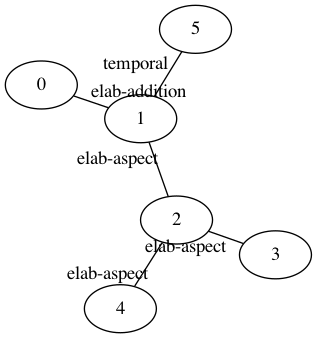

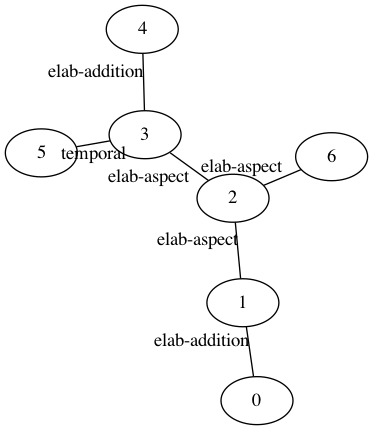

In [81]:
for x in uniques_attr(assert_attr_subs, pmrod):
    draw_graph(x)

In [82]:
sim_diff = sim_diff_attr(assert_gphs, prop_gphs)

NameError: name 'sim_diff_attr' is not defined

In [ ]:
nx.is_isomorphic(cop, prop_gphs[0])

In [ ]:
def is_spe(objs, othertypesobjs):
    """
     returns true if the set of objs is specific (not appears in other types objs)
    """
    isspe = True
    for obj in objs:
        if obj in othertypesobjs:
            isspe = False
            break
    return isspe

In [ ]:
args_per_type_gspan_out["proposal"][1]

## Distrib all lengths

In [ ]:
#all_lens = [y for y in types_lens.values() for sublist in x]
all_lens = [item for sublist in types_lens.values() for item in sublist]

In [ ]:
Counter(all_lens)